In [1]:
#Necessary Imports
import requests
import json
import pandas as pd
import plotly.graph_objects as go
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

In [2]:
# Hyperparameters
FUNCTION = 'FX_DAILY'
FROM_SYMBOL = 'EUR'
TO_SYMBOL = 'USD'
#SYMBOL = ''
INTERVAL = '1min' # '5min'
#ADJUSTED = '' # 'true' or 'false'
OUTPUT_SIZE = 'full' # 'full'
KEY = 'G305G16UG3DKD4YL'

In [3]:
# Price requesting function
def request_daily_price(function, from_currency, to_currency, interval, output_size, key):
  REQ_STRING='https://www.alphavantage.co/query?function='+function+'&from_symbol='+FROM_SYMBOL+'&to_symbol='+TO_SYMBOL+'&interval='+interval+'&outputsize='+output_size+'&apikey='+key
  response = requests.get(REQ_STRING).text
  response_info = json.loads(response)
  #print(response_info)
  df = pd.DataFrame(data=response_info['Time Series FX (Daily)']).T.astype(float)
  return df

In [4]:
#Requesting price
price_df = request_daily_price(FUNCTION, FROM_SYMBOL, TO_SYMBOL, INTERVAL, OUTPUT_SIZE, KEY)
price_df

,1. open,2. high,3. low,4. close
2021-04-16,1.19690,1.19948,1.19490,1.19823
2021-04-15,1.19789,1.19933,1.19540,1.19654
2021-04-14,1.19488,1.19874,1.19470,1.19781
2021-04-13,1.19118,1.19559,1.18766,1.19493
2021-04-12,1.18963,1.19192,1.18690,1.19107
...,...,...,...,...
2002-02-21,0.87000,0.87200,0.86770,0.86860
2002-02-20,0.87560,0.87820,0.86970,0.87020
2002-02-19,0.87060,0.87820,0.86570,0.87580
2002-02-18,0.87330,0.87420,0.86970,0.87050


In [13]:
#Plotting Price Data as Candestick Chart
fig = go.Figure(data=[go.Candlestick(x=price_df.index,
                open=price_df['1. open'],
                high=price_df['2. high'],
                low=price_df['3. low'],
                close=price_df['4. close'])])

fig.show()

In [6]:
#Preparing our Data for Training
split = 0.90
cl = price_df['4. close'][0:int(len(price_df['4. close'])*split)]
                              
scl = MinMaxScaler()
train = cl[0:int(len(cl)*split)]
lb=30

#Scale the data
scl.fit(train.values.reshape(-1,1))
cl =scl.transform(cl.values.reshape(-1,1))

def processData(data,lb):
    X,Y = [],[]
    for i in range(len(data)-lb-1):
        X.append(data[i:(i+lb)])
        Y.append(data[(i+lb)])
    return np.array(X),np.array(Y)

X,Y = processData(cl,lb)

splitter = int(len(Y)*split)
X_train,X_test = X[:splitter],X[splitter:]
Y_train,Y_test = Y[:splitter],Y[splitter:]

In [9]:
#Build the model
model = Sequential()
model.add(LSTM(256,input_shape=(lb,1)))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')

#Reshape data for (Sample,Timestep,Features) 
X_train = X_train.reshape((X_train.shape[0],X_train.shape[1],1))
X_test = X_test.reshape((X_test.shape[0],X_test.shape[1],1))

#Fit model with history to check for overfitting
history = model.fit(X_train,Y_train,epochs=300,validation_data=(X_test,Y_test),shuffle=False)
model.summary()

Epoch 1/300
126/126 [==============================] - 3s 10ms/step - loss: 0.0108 - val_loss: 0.0021
Epoch 2/300
126/126 [==============================] - 1s 5ms/step - loss: 0.0032 - val_loss: 0.0017
Epoch 3/300
126/126 [==============================] - 1s 5ms/step - loss: 0.0020 - val_loss: 8.9241e-04
Epoch 4/300
126/126 [==============================] - 1s 5ms/step - loss: 0.0010 - val_loss: 5.1176e-04
Epoch 5/300
126/126 [==============================] - 1s 5ms/step - loss: 5.3420e-04 - val_loss: 3.6456e-04
Epoch 6/300
126/126 [==============================] - 1s 5ms/step - loss: 4.2870e-04 - val_loss: 3.5773e-04
Epoch 7/300
126/126 [==============================] - 1s 5ms/step - loss: 4.4268e-04 - val_loss: 3.6559e-04
Epoch 8/300
126/126 [==============================] - 1s 6ms/step - loss: 4.8845e-04 - val_loss: 3.7005e-04
Epoch 9/300
126/126 [==============================] - 1s 6ms/step - loss: 5.2321e-04 - val_loss: 3.6437e-04
Epoch 10/300
126/126 [====================

Text(0.5, 1.0, 'Train Dataset')

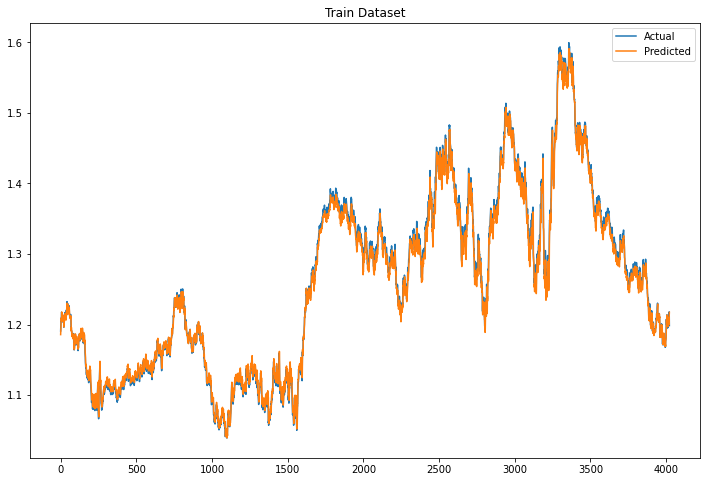

In [11]:
plt.figure(figsize=(12,8))

Xt = model.predict(X_train)
plt.plot(scl.inverse_transform(Y_train.reshape(-1,1)), label="Actual")
plt.plot(scl.inverse_transform(Xt), label="Predicted")
plt.legend()
plt.title("Train Dataset")

Text(0.5, 1.0, 'Test Dataset')

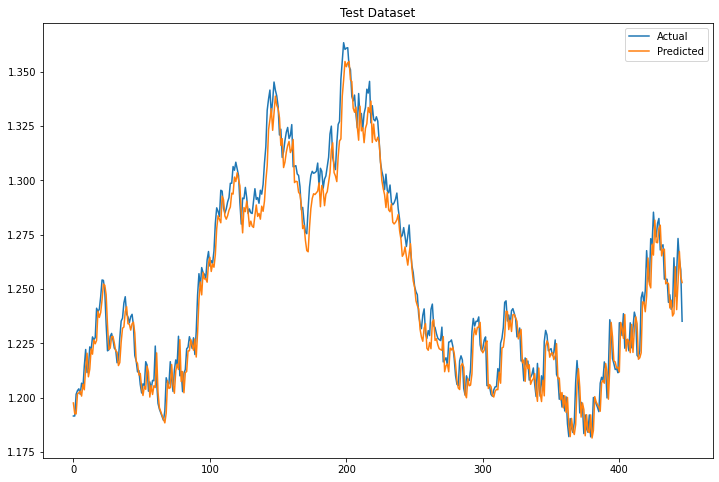

In [12]:
plt.figure(figsize=(12,8))
Xt = model.predict(X_test)
plt.plot(scl.inverse_transform(Y_test.reshape(-1,1)), label="Actual")
plt.plot(scl.inverse_transform(Xt), label="Predicted")
plt.legend()
plt.title("Test Dataset")